# Imports / data loads
Для простоты, просто повторю код загрузки из предыдущего джупитера

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import utils.eda
from utils.titanic_feature_generator import Titanic_Feature_Generator
from tqdm.notebook import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_base = pd.read_csv('data/train.csv', index_col='PassengerId')

# переименуем Survived в target для удобства
# и все наименования колонок приведем к единому регистру
df_base.columns = df_base.columns.str.lower()
df_base = df_base.rename(columns={'survived': 'target'})

In [3]:
from sklearn.model_selection import train_test_split

# Стратифицируем по целевой и по полу, так как мы заранее знаешь, что пол это сильный предиктор 
# и мы не ожидаем сильного смещения в распределении этой переменной в "реальных" данных
X_train, X_test, y_train, y_test = train_test_split(df_base.drop(columns='target'),
                                                    df_base['target'], 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    stratify=df_base[['target', 'sex']])

# Для удобства EDA склеим в датафреймы (с памятью проблем у нас тут нет)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

utils.eda.make_splits_info(df_train, df_test)

,size,mean target
train,668,0.383234
test,223,0.385650


# Base feature selection

## Generating features
Импортируем наш трансформер на основе полученных ранеее функций

In [4]:
from utils.titanic_feature_generator import Titanic_Feature_Generator

In [5]:
feat_get = Titanic_Feature_Generator()

# Сразу трансформируем для удобства оценки предикторов (но потом будем применять в пайплайнах)
X_train_tr = feat_get.fit_transform(X_train, y_train)
X_test_tr = feat_get.transform(X_test)

In [6]:
# Ранее определенные коррелируемые предикторы
high_corr_cols = ['n_cabins', 'n_relatives']

X_train_tr = X_train_tr.drop(columns=high_corr_cols)
X_test_tr = X_test_tr.drop(columns=high_corr_cols)

In [22]:
X_train_tr.head()

,pclass,age,sibsp,parch,fare,embarked,name_size,name_length,name_longest,name_length_mean,popular_name,has_mr,has_miss,has_mrs,has_master,has_dr,has_rev,has_rare_title,ticket_num_len,ticket_has_text,has_cabin,cabin_letter,alone,sex_male
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,
134,2,29.0,1,0,26.0000,S,5,37,9.0,6.6,0,0,0,1,0,0,0,0,6.0,0,0,NaN,0,0
151,2,51.0,0,0,12.5250,S,3,20,7.0,6.0,1,0,0,0,0,0,1,0,4.0,1,0,NaN,1,1
112,3,14.5,1,0,14.4542,C,2,13,6.0,6.0,0,0,1,0,0,0,0,0,4.0,0,0,NaN,0,0
629,3,26.0,0,0,7.8958,S,2,20,11.0,9.5,0,1,0,0,0,0,0,0,6.0,0,0,NaN,1,1
649,3,NaN,0,0,7.5500,S,2,13,6.0,6.0,0,1,0,0,0,0,0,0,3.0,1,0,NaN,1,1


## Variable IVs
Использую WOE транформацию из своего прошлого проекта по созданию ВОЕ транформера.

In [7]:
from utils.woe_transformer import WoE_Transformer
from utils.woe_transformer import WoE_groups_filter

In [8]:
# Инициализируем трансформер
woe_filter = WoE_groups_filter()
woe_trans = WoE_Transformer(unknown_vals='woe_mean',  
                            filter_groups_algo=woe_filter,
                           categorical_cols=['pclass', ])

In [9]:
# Также сразу трансформируем для проверки работы
X_train_woe = woe_trans.fit_transform(X_train_tr, y_train)
X_test_woe = woe_trans.transform(X_test_tr)

In [10]:
X_train_woe.head()

,pclass,age,sibsp,parch,fare,embarked,name_size,name_length,name_longest,name_length_mean,popular_name,has_mr,has_miss,has_mrs,has_master,has_dr,has_rev,has_rare_title,ticket_num_len,ticket_has_text,has_cabin,cabin_letter,alone,sex_male
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,
134,-0.490661,-0.130576,-0.059422,0.042193,-0.381535,0.203818,-1.574458,-1.200742,-0.182859,0.016631,-0.066764,-1.314501,0.368753,-1.770573,0.032477,-0.003394,-0.007805,0.026883,0.250717,0.016631,0.386378,0.386378,-0.453867,-1.524027
151,-0.490661,0.012507,-0.059422,0.042193,-0.070381,0.203818,0.269487,0.344053,0.411457,0.197099,0.152763,-1.314501,0.368753,0.285930,0.032477,-0.003394,1.605547,0.026883,0.377266,-0.046513,0.386378,0.386378,0.341492,0.978221
112,0.706299,-0.644922,-0.059422,0.042193,-0.070381,-0.681154,0.269487,0.401873,0.061737,0.197099,-0.066764,-1.314501,-1.312887,0.285930,0.032477,-0.003394,-0.007805,0.026883,0.377266,0.016631,0.386378,0.386378,-0.453867,-1.524027
629,0.706299,-0.130576,-0.059422,0.042193,0.904750,0.203818,0.269487,0.344053,-0.258781,0.018173,-0.066764,1.161329,0.368753,0.285930,0.032477,-0.003394,-0.007805,0.026883,0.250717,0.016631,0.386378,0.386378,0.341492,0.978221
649,0.706299,0.424941,-0.059422,0.042193,0.904750,0.203818,0.269487,0.401873,0.061737,0.197099,-0.066764,1.161329,0.368753,0.285930,0.032477,-0.003394,-0.007805,0.026883,0.377266,-0.046513,0.386378,0.386378,0.341492,0.978221


Получили WOE таблицы. На них можем посчитать IV предикторов

In [11]:
woe_trans.woe_tables['fare']

target,0,1,woe
group,,,
"(-inf, 8.0]",175,44,0.904750
"(8.0, 12.4]",48,20,0.399623
"(12.4, 19.3]",57,38,-0.070381
"(19.3, 56.5]",100,91,-0.381535
"(56.5, inf]",32,63,-1.153245


## Считаем Information Value

In [12]:
# Считаем IVs
vars_ivs = {}

for key, woe_table in woe_trans.woe_tables.items():
    size_0, size_1 = woe_table[[0, 1]].sum()
    vars_ivs[key] = woe_table.apply(lambda x: (x[0] / size_0 - x[1] / size_1) * x['woe'], axis=1).sum()
    
vars_ivs = pd.Series(vars_ivs).sort_values()

In [109]:
pd.DataFrame(vars_ivs, columns=['IV'])

,IV
ticket_has_text,0.000773
has_dr,0.002113
popular_name,0.010190
parch,0.013387
has_rev,0.015664
has_master,0.022157
name_length_mean,0.022920
sibsp,0.040966
has_rare_title,0.049862
name_longest,0.081308


## Catboost inside algo
И ещё посмотрим, что скажет алгоритм кэбуста. Запустим его отбор предикторов

In [21]:
import catboost as cb

In [26]:
# заполним пустые в кат фичах для кэтбуста
cat_feat = ['embarked', 'cabin_letter']

X_train_cb = X_train_tr.copy()
X_train_cb[cat_feat] = X_train_cb[cat_feat].fillna('missing')
X_test_cb = X_test_tr.copy()
X_test_cb[cat_feat] = X_test_cb[cat_feat].fillna('missing')

In [27]:
params = {'iterations': 100, # Сделаем поменьше
          'eval_metric': 'AUC',
              'silent':True,
              'random_state': 123,        
              }

cb_model = cb.CatBoostClassifier(**params)

train_pool = cb.Pool(X_train_cb, y_train, 
                     cat_features=cat_feat)

test_pool = cb.Pool(X_test_cb, y_test, 
                     cat_features=cat_feat)

In [28]:
select_feat = X_train_cb.columns.tolist()

# Отбираем предикторы
summary = cb_model.select_features(train_pool,
    eval_set=test_pool,
    features_for_select=select_feat,
    num_features_to_select=1,  
    steps=len(select_feat)-1,
    algorithm=cb.EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=cb.EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
# summary['selected_features_names']
f_data = {'features': [''] + summary['eliminated_features_names'],
       'losses': summary['loss_graph']['loss_values']}
f_data = pd.DataFrame(f_data)
f_data

,features,losses
0,,0.380060
1,has_dr,0.384007
2,ticket_has_text,0.387507
3,ticket_num_len,0.388726
4,has_rare_title,0.404594
5,popular_name,0.389670
6,alone,0.372592
7,has_mrs,0.370041
8,name_longest,0.369051
9,has_rev,0.367508


In [38]:
# Сделаем пару наборов
good_feat = f_data['features'][18:].tolist() + summary['selected_features_names']

potent_good_feat = f_data['features'][11:].tolist() + summary['selected_features_names']

all_feat = select_feat.copy()

In [40]:
print(all_feat)

['pclass', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'name_size', 'name_length', 'name_longest', 'name_length_mean', 'popular_name', 'has_mr ', 'has_miss ', 'has_mrs ', 'has_master ', 'has_dr ', 'has_rev ', 'has_rare_title', 'ticket_num_len', 'ticket_has_text', 'has_cabin', 'cabin_letter', 'alone', 'sex_male']


In [42]:
print(potent_good_feat)

['parch', 'name_size', 'name_length_mean', 'embarked', 'name_length', 'cabin_letter', 'has_master ', 'sibsp', 'age', 'fare', 'has_cabin', 'pclass', 'sex_male', 'has_mr ']


In [41]:
print(good_feat)

['sibsp', 'age', 'fare', 'has_cabin', 'pclass', 'sex_male', 'has_mr ']


# Cross-validation

Делаем 10 разных разбиений по 5 фолдов в каждом, итого получим 50 скоров.  
Будем сравнивать не средний скор моделей, а то, насколько каждая из моделей лучше или хуже другой на соответствующем фолде.  
Применять будем Т тест



In [20]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from scipy.stats import ttest_rel

Сначала просто попробуем работу. Сделаем 2 разных модели случайных лесов и выберем лучшую

Учим бэйслайн модель - случайный лес на 5 предикторах. Тут пустые значения наивным образом заполняем (средним для числовых, наиболее частым для категориальных)

In [49]:
baseline_cols = ['pclass', 'sex_male', 'age', 'sibsp', 'fare']

baseline_model = make_pipeline(Titanic_Feature_Generator(cols_to_keep=baseline_cols),
                                SimpleImputer(strategy='most_frequent'),
                              RandomForestClassifier(max_depth=4))

Для сравнения возьмем такой же случайный лес, добавим все предикторы, а для категориальных сделаем onehotencoder

In [50]:
# Подготавливаем препроцессинги для этой версии
numeric_transformer = SimpleImputer()
categorical_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                       OneHotEncoder(handle_unknown='ignore'))

all_feat_tranf = make_column_transformer(
                        (numeric_transformer,
                             make_column_selector(dtype_include=np.number)),
                        (categorical_transformer,
                             make_column_selector(dtype_include=object)))

all_feat_model = make_pipeline(Titanic_Feature_Generator(cols_to_keep=all_feat),
                               all_feat_tranf,
                              RandomForestClassifier(max_depth=4))

In [51]:
# Учимся все время на оригинальном X_train, и разбиваем его на фолды всегда одинакого

def train_score_folds(model):
    scores = np.array([])
    
    for i in range(10):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        
        scores_split = cross_val_score(estimator=model, X=X_train, y=y_train,
                                                        cv=fold, scoring='roc_auc')
        
        scores = np.append(scores, scores_split)
    
    return scores

def compare_scores(scores_base, scores_new, index=''):
    t_score, p_value = ttest_rel(scores_base, scores_new)
    score = [[t_score, p_value, scores_base.mean(), scores_new.mean()]]
    return pd.DataFrame(score, 
                        columns=['t_score', 'p_value', 'mean_base', 'mean_new'], 
                        index=[index])

In [52]:
scores_base = train_score_folds(baseline_model)

Пробуем. Итеративно идем по параметру max_depth для версии со всеми предикторами и сравниваем с бэслайном с 5 переменными

In [53]:
result = pd.DataFrame()

for max_depth in tqdm(range(5,15)):
    all_feat_model = make_pipeline(Titanic_Feature_Generator(cols_to_keep=all_feat),
                               all_feat_tranf,
                              RandomForestClassifier(max_depth=max_depth))
    
    scores_new = train_score_folds(all_feat_model)
    
    stats = compare_scores(scores_base, scores_new, index=max_depth)
    result = result.append(stats)

  0%|          | 0/10 [00:00<?, ?it/s]

In [54]:
result

,t_score,p_value,mean_base,mean_new
5,-3.421618,1.264653e-03,0.857477,0.864146
6,-4.953604,9.068900e-06,0.857477,0.868160
7,-5.933337,2.964311e-07,0.857477,0.870799
8,-5.802134,4.715297e-07,0.857477,0.872004
9,-6.210015,1.109813e-07,0.857477,0.873411
10,-6.975085,7.250197e-09,0.857477,0.874115
11,-5.595054,9.781043e-07,0.857477,0.872044
12,-5.983146,2.484583e-07,0.857477,0.873229
13,-5.978558,2.525338e-07,0.857477,0.873743
14,-5.932701,2.970990e-07,0.857477,0.872296


In [58]:
def plot_model_comparison(result, xname='', title=''):
    fig, ax = plt.subplots() # figsize=(16, 4)
    ax2 = ax.twinx()

    result['t_score'].plot(ax=ax, label='t_score')
    result['mean_new'].plot(ax=ax2, label='mean roc_auc', c='g')
    ax.set_xlabel(xname)
    ax.legend()
    ax2.legend()
    plt.title(title);

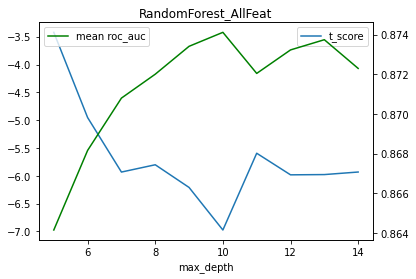

In [59]:
plot_model_comparison(result, xname='max_depth', title='RandomForest_AllFeat')

Т статистика оказалась наилучшей c max_depth=10, и средний скор лучший в этом районе.  

Зафиксируем тестовый скор этой модели и продолжим сравнивать модели этим методом

In [61]:
def roc_auc_train_test(model):
    model.fit(X_train, y_train)
    preds_train = model.predict_proba(X_train)[:, 1]
    preds_test = model.predict_proba(X_test)[:, 1]
    
    roc_train = roc_auc_score(y_train, preds_train)
    roc_test = roc_auc_score(y_test, preds_test)
    
    return roc_train, roc_test

In [66]:
feaute_sample_names = ['все', 'потенциальные', 'хорошие']
feaute_samples = [all_feat, potent_good_feat, good_feat]

for _feature_sample, fname in zip(feaute_samples, feaute_sample_names):
    rand_forest_all_f = make_pipeline(Titanic_Feature_Generator(cols_to_keep=_feature_sample),
                               all_feat_tranf,
                              RandomForestClassifier(max_depth=10))

    scores_rf_all_f = roc_auc_train_test(rand_forest_all_f)
    print(f'Предикторы: {fname}')
    print(f"train = {scores_rf_all_f[0]:.4f}\ntest = {scores_rf_all_f[1]:.4f}")

Предикторы: все
train = 0.9905
test = 0.8934
Предикторы: потенциальные
train = 0.9874
test = 0.8939
Предикторы: хорошие
train = 0.9860
test = 0.8953


# WOE+LR model

Теперь бэслайном будет лучшая из предыдущего эксперимента

In [68]:
rand_forest_all_f = make_pipeline(Titanic_Feature_Generator(cols_to_drop=high_corr_cols),
                               all_feat_tranf,
                              RandomForestClassifier(max_depth=9))

scores_base = train_score_folds(rand_forest_all_f)

Берем все предикторы

In [70]:
result = pd.DataFrame()

for max_groups in tqdm(range(2, 17, 2)):
    # Инициализируем woe трансформер
    woe_trans = WoE_Transformer(num_intervals=max_groups+int(max_groups/2)+1,
                            max_groups=max_groups,
                            unknown_vals='woe_mean',  
                            filter_groups_algo=woe_filter,
                           categorical_cols=['pclass', ])
    
    woe_lr_model = make_pipeline(Titanic_Feature_Generator(cols_to_keep=all_feat),
                              woe_trans,
                              LogisticRegression())
    
    scores_new = train_score_folds(woe_lr_model)
    
    stats = compare_scores(scores_base, scores_new, index=max_groups)
    result = result.append(stats)

  0%|          | 0/8 [00:00<?, ?it/s]

In [71]:
result

,t_score,p_value,mean_base,mean_new
2,7.585335,8.268606e-10,0.875016,0.852754
4,10.595414,2.850025e-14,0.875016,0.848521
6,10.106246,1.415791e-13,0.875016,0.849588
8,11.168581,4.526049e-15,0.875016,0.847253
10,10.881901,1.130198e-14,0.875016,0.846771
12,11.219481,3.851509e-15,0.875016,0.845953
14,11.199541,4.102710e-15,0.875016,0.844691
16,11.493356,1.625530e-15,0.875016,0.844766


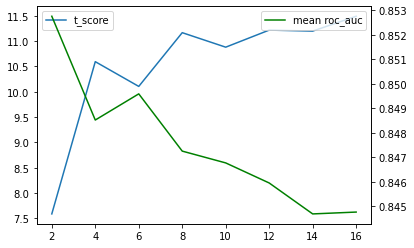

In [72]:
plot_model_comparison(result)

Неудачно, скоры модели явно хуже. Попробуем взять меньший набор переменных.  
Возьмем только хорошие

In [73]:
result = pd.DataFrame()

for max_groups in tqdm(range(2, 17, 2)):
    # Инициализируем woe трансформер
    woe_trans = WoE_Transformer(num_intervals=max_groups+int(max_groups/2),
                            max_groups=max_groups,
                            unknown_vals='woe_mean',  
                            filter_groups_algo=woe_filter,
                           categorical_cols=['pclass', ])
    # изменили базовый набор предикторов
    woe_lr_model = make_pipeline(Titanic_Feature_Generator(cols_to_keep=good_feat),
                              woe_trans,
                              LogisticRegression())
    
    scores_new = train_score_folds(woe_lr_model)
    
    stats = compare_scores(scores_base, scores_new, index=max_groups)
    result = result.append(stats)

  0%|          | 0/8 [00:00<?, ?it/s]

In [74]:
result

,t_score,p_value,mean_base,mean_new
2,10.915356,1.015175e-14,0.875016,0.842977
4,8.757145,1.360702e-11,0.875016,0.849401
6,8.692651,1.700768e-11,0.875016,0.850750
8,8.734317,1.472431e-11,0.875016,0.848810
10,8.958471,6.799333e-12,0.875016,0.848343
12,8.232834,8.435609e-11,0.875016,0.849167
14,10.645921,2.419381e-14,0.875016,0.845624
16,10.899038,1.069717e-14,0.875016,0.845514


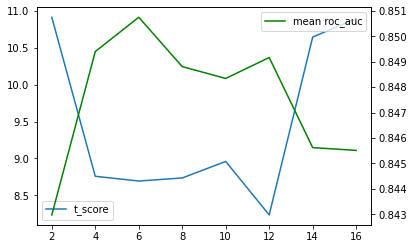

In [75]:
plot_model_comparison(result)

Результаты несколько лучше чем на всех предикторах, но все равно не лучше предыдущей модели.  
Зафиксируем лучшую модель по бинам и её скоры на тесте на разных наборах предикторов

In [76]:
feaute_sample_names = ['все', 'потенциальные', 'хорошие']
feaute_samples = [all_feat, potent_good_feat, good_feat]

for _feature_sample, fname in zip(feaute_samples, feaute_sample_names):
    woe_trans = WoE_Transformer(num_intervals=6,
                        max_groups=4,
                        unknown_vals='woe_mean',  
                        filter_groups_algo=woe_filter,
                       categorical_cols=['pclass', ])

    woe_lr_model = make_pipeline(Titanic_Feature_Generator(cols_to_keep=_feature_sample),
                              woe_trans,
                              LogisticRegression())
    
    scores_woe_lr_all = roc_auc_train_test(woe_lr_model)
    print(f'Предикторы: {fname}')
    print(f"train = {scores_woe_lr_all[0]:.4f}\ntest = {scores_woe_lr_all[1]:.4f}")

Предикторы: все
train = 0.8764
test = 0.8885
Предикторы: потенциальные
train = 0.8723
test = 0.8858
Предикторы: хорошие
train = 0.8593
test = 0.8659


# Catboost model

Базовые скоры не меняем, оставляем такими же.  
Итерируем через параметр iterations.  
Текстовые пропущенные значения, заполняем - 'missing'  
Набор предикторов - potent_good_feat

In [79]:
result = pd.DataFrame()

for iters in tqdm(range(40, 201, 20)):
    nan_to_miss_tr = ColumnTransformer([("cat_impute", SimpleImputer(fill_value='missing', strategy='constant'), 
                                      cat_feat),],
                                  remainder='passthrough')
    
    cb_classifier = cb.CatBoostClassifier(iterations=iters, 
                                          cat_features=[0,1],
                                         silent=True)
    
    cb_model = make_pipeline(Titanic_Feature_Generator(cols_to_keep=potent_good_feat),
                             nan_to_miss_tr,
                              cb_classifier)
    
    scores_new = train_score_folds(cb_model)
    
    stats = compare_scores(scores_base, scores_new, index=iters)
    result = result.append(stats)

  0%|          | 0/9 [00:00<?, ?it/s]

In [80]:
result

,t_score,p_value,mean_base,mean_new
40,9.614267,7.308126e-13,0.875016,0.855865
60,9.267891,2.359972e-12,0.875016,0.857263
80,9.025085,5.409572e-12,0.875016,0.857361
100,8.647854,1.986274e-11,0.875016,0.857180
120,9.255581,2.460968e-12,0.875016,0.857354
140,9.269479,2.347254e-12,0.875016,0.857547
160,8.704280,1.633670e-11,0.875016,0.857802
180,9.368640,1.675833e-12,0.875016,0.856799
200,8.260094,7.667757e-11,0.875016,0.856405


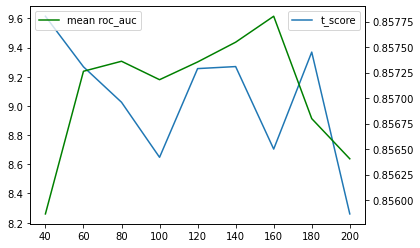

In [81]:
plot_model_comparison(result)

Зафиксируем результат на тесте

In [91]:
feaute_sample_names = ['все', 'потенциальные', 'хорошие']
feaute_samples = [all_feat, potent_good_feat, good_feat]

for _feature_sample, fname in zip(feaute_samples, feaute_sample_names):
    categorical = list(set(cat_feat) & set(_feature_sample))
    # fill categorical nans as missing
    nan_to_miss_tr = ColumnTransformer([("cat_impute", SimpleImputer(fill_value='missing', strategy='constant'), 
                                      categorical),],
                                  remainder='passthrough')
    
    cb_classifier = cb.CatBoostClassifier(iterations=200, 
                                      cat_features=list(range(len(categorical))),
                                     silent=True)

    catboost_model = make_pipeline(Titanic_Feature_Generator(cols_to_keep=_feature_sample),
                         nan_to_miss_tr,
                          cb_classifier)

    
    scores_cb = roc_auc_train_test(catboost_model)
    print(f'Предикторы: {fname}')
    print(f"train = {scores_cb[0]:.4f}\ntest = {scores_cb[1]:.4f}")

Предикторы: все
train = 0.9545
test = 0.9026
Предикторы: потенциальные
train = 0.9413
test = 0.9015
Предикторы: хорошие
train = 0.9485
test = 0.9010


# Ensemble

Создадим простой soft voting классификатор на основе полученных 3х лучших моделей разных типов

In [93]:
from sklearn.ensemble import VotingClassifier

In [104]:
woe_filter = WoE_groups_filter()
# Инициализируем woe трансформер
woe_trans = WoE_Transformer(num_intervals=max_groups+int(max_groups/2),
                        max_groups=max_groups,
                        unknown_vals='woe_mean',  
                        filter_groups_algo=woe_filter,
                       categorical_cols=['pclass', ])

In [102]:
voting_model = VotingClassifier([('rf', rand_forest_all_f), 
                                 ('woe_lr', woe_lr_model), 
                                 ('cat_boost', catboost_model)],
                               voting='soft',
                               weights=None,
                               n_jobs=1,
                               flatten_transform=False)

In [106]:
feaute_sample_names = ['все', 'потенциальные', 'хорошие']
feaute_samples = [all_feat, potent_good_feat, good_feat]

for _feature_sample, fname in zip(feaute_samples, feaute_sample_names):
    
    rand_forest_all_f = make_pipeline(Titanic_Feature_Generator(cols_to_keep=_feature_sample),
                                   all_feat_tranf,
                                  RandomForestClassifier(max_depth=9))

    woe_lr_model = make_pipeline(Titanic_Feature_Generator(cols_to_keep=_feature_sample),
                              woe_trans,
                              LogisticRegression())

    categorical = list(set(cat_feat) & set(_feature_sample))
    
    nan_to_miss_tr = ColumnTransformer([("cat_impute", SimpleImputer(fill_value='missing', strategy='constant'), 
                                          categorical),],
                                      remainder='passthrough')

    catboost_model = make_pipeline(Titanic_Feature_Generator(cols_to_keep=_feature_sample),
                             nan_to_miss_tr,
                              cb.CatBoostClassifier(iterations= 200, 
                                          cat_features=list(range(len(categorical))),
                                         silent=True))
    
    voting_model = VotingClassifier([('rf', rand_forest_all_f), 
                             ('woe_lr', woe_lr_model), 
                             ('cat_boost', catboost_model)],
                           voting='soft',
                           weights=None,
                           flatten_transform=False)
    
    scores_voting = roc_auc_train_test(voting_model)
    print(f'Предикторы: {fname}')
    print(f"train = {scores_voting[0]:.4f}\ntest = {scores_voting[1]:.4f}")

Предикторы: все
train = 0.9563
test = 0.9015
Предикторы: потенциальные
train = 0.9488
test = 0.8981
Предикторы: хорошие
train = 0.9502
test = 0.8947


# Saving model
Финальной версией приложу кэтбуст модель на "хороших предикторах"

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class TitanicFinalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols_top_keep = ['sibsp', 'age', 'fare', 'has_cabin', 'pclass', 'sex_male', 'has_mr ']
        
    def fit(self, X=None, y=None):
        return self
        
    def transform(self, X, y=None):
        X = X.copy()
        X['has_cabin'] = X['cabin'].notna().astype(int)
        X['sex_male'] = (X['sex'] == 'male').astype(int)
        
        name_clear = X['name'].str.lower().str.strip()
        punct_signs = ['.', ',', '(', ')', '', "'", '"']
        for char in punct_signs:
            name_clear = name_clear.str.replace(char, '', regex=False)
        name_clear = name_clear.str.replace(' +', ' ', regex=True)
                                                            
        X[f'has_mr '] = name_clear.str.contains('mr ').astype(int)
        
        return X[self.cols_top_keep]

In [22]:
final_model = make_pipeline(TitanicFinalTransformer(),
                           cb.CatBoostClassifier(iterations=200, silent=True))

In [23]:
# Фиттим модель
final_model.fit(X_train, y_train)

final_preds = final_model.predict_proba(X_test)[:, 1]
print(f"gini score = {2 * roc_auc_score(y_test, final_preds) - 1}")

gini score = 0.8020709556951282


In [29]:
with open('models/cat_boost_7feat_200it.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Bonus - shap

Посмотрим на catboost модель, обученную только на сэмпле "хороших" предикторов

In [111]:
import shap

In [231]:
# Заного перетрансформируем для удобства.
feat_gen = Titanic_Feature_Generator(cols_to_keep=good_feat)

X_train_trf = feat_gen.fit_transform(X_train)
X_test_trf = feat_gen.transform(X_test)

In [232]:
# Фиттим модель
cb_model_g = cb.CatBoostClassifier(iterations=200, silent=True,)
cb_model_g.fit(X_train_trf, y_train)

cb_preds = cb_model_g.predict_proba(X_test_trf)[:, 1]
print(f"gini score = {2 * roc_auc_score(y_test, cb_preds) - 1}")

gini score = 0.8019012052283145


In [233]:
# Ищем неверно классифицированные примеры
thresh = 0.5
corr_mask = ((cb_preds >= thresh) & (y_test==1)) | (cb_preds < thresh) & (y_test==0)
err_mask = ~corr_mask

corr_idxs = np.where(corr_mask)[0]
err_idxs = np.where(err_mask)[0]

corr_mask.sum(), err_mask.sum()

(187, 36)

In [234]:
# инициализируем shap
explainer = shap.Explainer(cb_model_g)
shap_values = explainer(X_test_trf)

passenger not survived
predicted survival 0.906


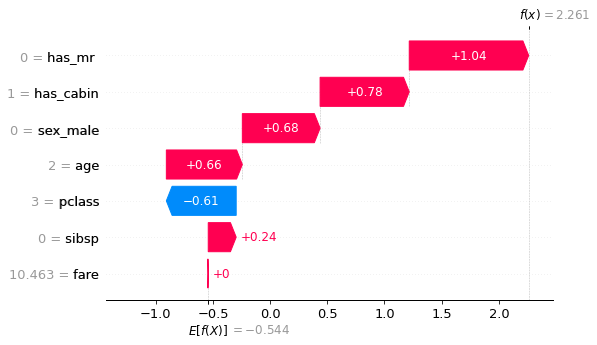

In [189]:
i = 2
print(f"passenger {'survived' if y_test.iloc[err_idxs[i]]==1 else 'not survived'}")
print(f"predicted survival {cb_preds[err_idxs[i]]:.3f}")
shap.plots.waterfall(shap_values[err_idxs[i]])

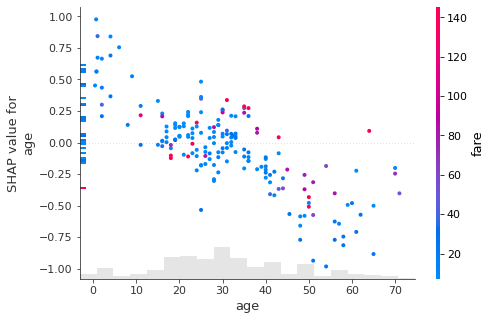

In [217]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, 1], color=shap_values)

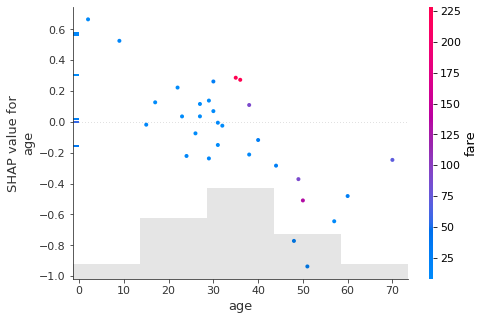

In [214]:
# Только ошибки
shap.plots.scatter(shap_values[err_idxs, 1], color=shap_values[err_idxs])

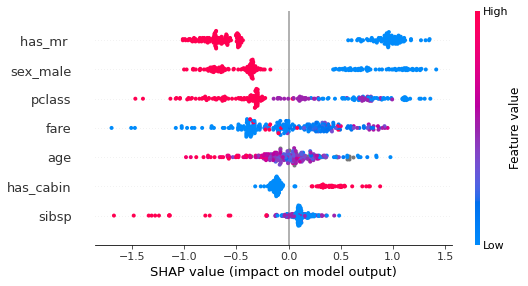

In [205]:
shap.plots.beeswarm(shap_values)

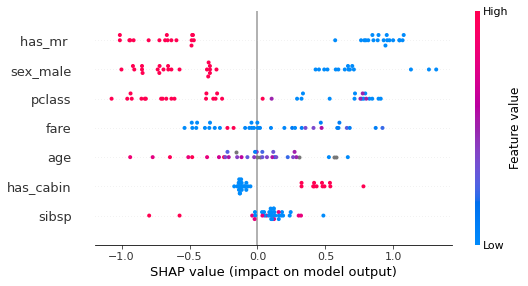

In [215]:
# только ошибки
shap.plots.beeswarm(shap_values[err_idxs])

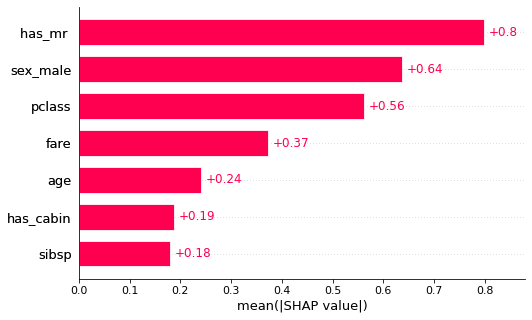

In [212]:
shap.plots.bar(shap_values)